In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

import myokit
from scipy.integrate import ode, solve_ivp
sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Protocols')
from pacing_protocol import PacingProtocol
import mod_protocols
sys.path.append('../models')
from Models.ord2011 import ORD2011

In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
end_time = 500
bcl = 1000
duration = 0.5
offset = 20

In [3]:
a = [-87.99697547749032, 7.096321518112385, 7.096404290494018, 144.8304082113188, 144.83038391742753, 8.568928274107874e-05, 8.463271033652429e-05, 1.6037834806338052, 1.5536428004491096, 0.007347762481645693, 0.697936461145313, 0.6979182033452321, 0.6978158639529485, 0.4547453323348951, 0.6977470443923227, 0.0001884380670952559, 0.49989442318436483, 0.2679266473893076, 0.0010014305596707563, 0.9995537876071112, 0.5801452425634359, 0.0005102559843220271, 0.9995537956260864, 0.6326168674251693, 2.3435233442418746e-09, 0.999999990862488, 0.9075386190063421, 0.9999999908625554, 0.9997677469406823, 0.9999652173989056, 0.002712610199016676, 0.9999999908620326, 0.9999999908595661, 8.263686649689228e-06, 0.46143060561991744, 0.2753638673999758, 0.000192958992421993, 0.9967610690978087, 2.403290978837076e-07, 3.0023854223905535e-07, 0.012377484610423357]
b = [-87.93653448517782, 7.499178544530731, 7.499254669070625, 144.3616914921008, 144.36166445794998, 7.59342348681183e-05, 7.499529503394359e-05, 1.9680749034792357, 1.9070937585440166, 0.007392557295371753, 0.6958387567328437, 0.6958277200352065, 0.6957637282692158, 0.45231064497048484, 0.695718832704746, 0.00019061373044554857, 0.5008706398574784, 0.2740122025033474, 0.0010055168710729758, 0.9995491014617318, 0.9995383994363888, 0.0005123390984921641, 0.9995491018064401, 0.9995467138399825, 2.377235084683379e-09, 0.9999999907126026, 0.9184967760249303, 0.9999999907126444, 0.9998549025755935, 0.9999781008842502, 0.0017053738733506698, 0.9999999907106037, 0.9999999907107742, 8.150812051521697e-06, 0.4366577200287514, 0.2495538290465403, 0.00019424397115646203, 0.9967767557823464, 4.5085246443361706e-07, 5.634454491343157e-07, 0.015526378726033043]
c = [-87.71815424079526, 8.34610076580103, 8.346220867062161, 143.51723511116603, 143.51720755505454, 9.27848409559049e-05, 9.079573594281579e-05, 1.9419765866099288, 1.8615469547508838, 0.007556681180023667, 0.6881912036810729, 0.6881651312317851, 0.6880164406496969, 0.44338294913451953, 0.6879130228908704, 0.00019868632439958283, 0.4837529559466092, 0.24577190092238366, 0.0010204323811995118, 0.9995314467764733, 0.5419037991536735, 0.0005199427775340963, 0.99953145845905, 0.5882669556391358, 2.50321676071934e-09, 0.999999990145673, 0.868209682573566, 0.9999999901457779, 0.9994775526824476, 0.9999298260261735, 0.0035498762940489033, 0.9999999901412451, 0.9999999901412105, 8.822770100814404e-06, 0.5004333691590932, 0.34057727355634065, 0.0001991056169864157, 0.9968336805088868, 1.60495006023744e-06, 2.005531045150147e-06, 0.023371326456743738]
y0 = [a, b, c]

In [4]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011.mmt" 

protocol_myokit = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0
sim_myokit = simulator_myokit.Simulator(model_path, protocol_myokit, max_step=None, abs_tol=1e-08, rel_tol=1e-10)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ORD2011"
sim_myokit.bcl = bcl

times = np.linspace(0, end_time, 5000)

simulated_models_myokit = []
for name, mode in cells.items():    
    start_time = time.time()
    
    sim_myokit.simulation.set_constant('cell.mode', mode)    
    d = sim_myokit.simulate(times, pre_sim_type=2)
    simulated_models_myokit.append(d)
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 0.03234982490539551 seconds ---
--- 0.03537607192993164 seconds ---
--- 0.03269505500793457 seconds ---


In [5]:
import simulator_scipy
'''
Simulation with BDF
'''
protocol = PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
model = ORD2011(protocol)
sim_bdf = simulator_scipy.Simulator(model)
t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

simulated_models_BDF = []
for name, mode in cells.items(): 
    start_time = time.time()

    model.cell.mode = mode

    sim_bdf.pre_simulate( pre_step=bcl*100, protocol='constant' )        

    sim_bdf.simulate(t_span=t_span, t_eval=t_eval, method='LSODA', max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10

    simulated_models_BDF.append(copy.copy(model))

    print("--- %s seconds ---"%(time.time()-start_time))

--- 3.5332107543945312 seconds ---
--- 3.998295783996582 seconds ---
--- 3.734478235244751 seconds ---


In [6]:
import simulator_euler
'''
Simulation with Euler
'''
protocol = PacingProtocol(level=1, start=20, length=0.5, period=1000, multiplier=0, default_time_unit='ms')
model = ORD2011(protocol)
sim_euler = simulator_euler.Simulator(model)

simulated_models_Euler = []
for name, mode in cells.items(): 
    start_time = time.time()
    
    model.cell.mode = mode    
    
    model.y0 = copy.copy(np.array(y0[mode]))
    
    sim_euler.dt = 0.02
    sim_euler.simulate(end_time=end_time)      
    simulated_models_Euler.append(copy.copy(model))
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 9.357818603515625 seconds ---
--- 9.503124237060547 seconds ---
--- 9.528144836425781 seconds ---


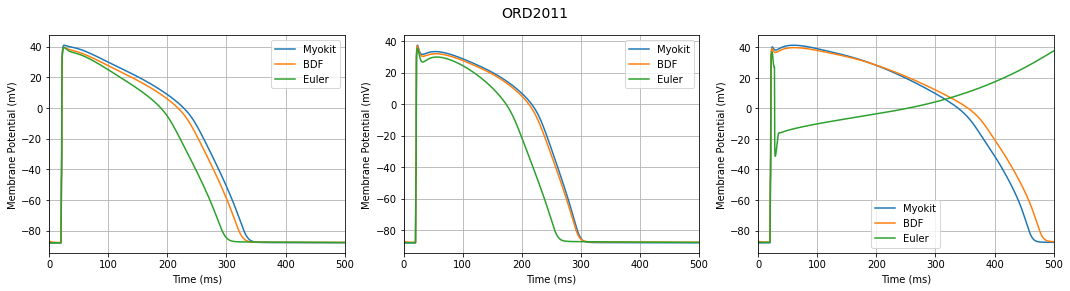

In [7]:
'''
Plot
'''
fig, axes = plt.subplots(1,3, figsize=(18,4))    
fig.suptitle(model.name, fontsize=14)
for name, mode in cells.items(): 
    myokit_m = simulated_models_myokit[mode]
    bdf_m = simulated_models_BDF[mode]      
    euler_m = simulated_models_Euler[mode]
    
    # ax.set_title('Simulation %d'%(simulationNo))
    axes[mode].set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[mode].set_ylabel('Membrane Potential (mV)')  
    axes[mode].set_xlabel('Time (ms)')       
    axes[mode].plot( myokit_m['engine.time'], myokit_m['membrane.V'], label='Myokit') 
    axes[mode].plot(bdf_m.times, bdf_m.V, label='BDF')   
    axes[mode].plot(euler_m.times, euler_m.V, label='Euler')   
    
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    axes[mode].legend()
    axes[mode].grid()
    
#     print(bdf.V)
#     print(euler.V)
#     print("-"*100)
    
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-all"), dpi=100)

In [8]:
print("Complete")

Complete
